In [1]:
from google.colab import drive

drive.mount("/content/drive")

Mounted at /content/drive


In [2]:
!nvidia-smi

Sat May  4 20:35:35 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off | 00000000:00:04.0 Off |                    0 |
| N/A   31C    P0              44W / 400W |      2MiB / 40960MiB |      0%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+--

In [3]:
!git clone https://github.com/rapidsai/rapidsai-csp-utils.git
!python rapidsai-csp-utils/colab/pip-install.py

Cloning into 'rapidsai-csp-utils'...
remote: Enumerating objects: 476, done.
remote: Counting objects: 100% (207/207), done.
remote: Compressing objects: 100% (116/116), done.
remote: Total 476 (delta 141), reused 124 (delta 91), pack-reused 269
Receiving objects: 100% (476/476), 131.59 KiB | 14.62 MiB/s, done.
Resolving deltas: 100% (243/243), done.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 2.0 MB/s eta 0:00:00
***********************************************************************
Woo! Your instance has a NVIDIA A100-SXM4-40GB GPU!
We will install the latest stable RAPIDS via pip 24.4.*!  Please stand by, should be quick...
***********************************************************************

Looking in indexes: https://pypi.org/simple, https://pypi.nvidia.com
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 473.3/473.3 MB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 GB 1.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1

In [4]:
from cuml.svm import SVC
import cudf

import pandas as pd
import nltk
import re
import random
import numpy as np
import matplotlib.pyplot as plt
from nltk.stem import PorterStemmer, WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score, accuracy_score, precision_score, roc_auc_score
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import GridSearchCV
from itertools import cycle
from nltk.corpus import stopwords


import pickle
import warnings

warnings.filterwarnings("ignore")

nltk.download("punkt")
nltk.download("stopwords")
nltk.download("wordnet")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [5]:
random_state = 42
testing_frac = 1
random.seed(random_state)
work_path = "/content/drive/MyDrive/Syncable/projects/data270"
data_path = f"{work_path}/data/combined.csv"

In [6]:
df = pd.read_csv(data_path, low_memory=False)
df = df.drop_duplicates()
df = df[["overall", "reviewText", "summary"]]
df.dropna(inplace=True)
df["sentiment"] = df["overall"].apply(lambda x: 1 if x > 3 else -1 if x < 3 else 0)
df["reviewTextWithSummary"] = df["summary"] + " " + df["reviewText"]
df.drop(["overall", "summary", "reviewText"], axis=1, inplace=True)
df.head()

,sentiment,reviewTextWithSummary
0,1,Five Stars As advertised. Reasonably priced
1,1,Good for the face Like the oder and the feel w...
2,-1,Smells awful I bought this to smell nice after...
3,1,Truth is There IS Nothing Like an AQUA VELVA M...
4,1,Bvlgari Shampoo If you ever want to feel pampe...


# Model experimentation

In [7]:
# df_testing = df.sample(frac=testing_frac)
df_testing = df
df_testing["sentiment"].value_counts()

sentiment
 1    606258
 0     43210
-1     41158
Name: count, dtype: int64

In [8]:
df_testing.head()

,sentiment,reviewTextWithSummary
0,1,Five Stars As advertised. Reasonably priced
1,1,Good for the face Like the oder and the feel w...
2,-1,Smells awful I bought this to smell nice after...
3,1,Truth is There IS Nothing Like an AQUA VELVA M...
4,1,Bvlgari Shampoo If you ever want to feel pampe...


In [9]:
print("Dataset size:", len(df_testing))

Dataset size: 690626


In [10]:
STOP_WORDS = set(stopwords.words("english"))

In [11]:
def preprocess_text(sentence, stop, type_proc=None):
    words = []
    for word in sentence.lower().strip().split():

        word = re.sub("\d", "", word)
        word = re.sub("[^\w\s]", "", word)

        if word not in stop and word != "":
            words.append(preprocess_type(word, type_proc))

    return " ".join(words)

In [12]:
def preprocess_type(word, type_proc):
    if type_proc == "Baseline":
        return word
    elif type_proc == "Stemmed":
        return PorterStemmer().stem(word)
    elif type_proc == "Lemmatized":
        return WordNetLemmatizer().lemmatize(word)
    else:
        raise ValueError("Invalid Preprocessing Type")

In [13]:
def train_val_test_split(df=df, random_state=random_state):
    x = df[["reviewTextWithSummary"]]
    y = df["sentiment"]
    x_train, x_tmp, y_train, y_tmp = train_test_split(
        x, y, test_size=0.3, random_state=random_state
    )
    x_val, x_test, y_val, y_test = train_test_split(
        x_tmp, y_tmp, test_size=0.5, random_state=random_state
    )
    return x_train, x_val, x_test, y_train, y_val, y_test

In [14]:
def pipeline(proc, df, vectorizer=None, random_state=random_state):
    df_ = df.copy()
    if proc is not None:
        df_["reviewTextWithSummary"] = df_["reviewTextWithSummary"].apply(
            lambda x: preprocess_text(x, STOP_WORDS, proc)
        )

    x_train, x_val, x_test, y_train, y_val, y_test = train_val_test_split(
        df_, random_state
    )
    if vectorizer is None:
        vectorizer = TfidfVectorizer()
        vectorizer.fit(df_["reviewTextWithSummary"])
    x_train = vectorizer.transform(x_train["reviewTextWithSummary"])
    x_val = vectorizer.transform(x_val["reviewTextWithSummary"])
    x_test = vectorizer.transform(x_test["reviewTextWithSummary"])

    return x_train, x_val, x_test, y_train, y_val, y_test, vectorizer

In [15]:
model_found = False
model = None
vectorizer = None
try:
    model = pickle.load(open(f"{work_path}/models/model_svm_clf.pkl", "rb"))
    vectorizer = pickle.load(open(f"{work_path}/models/model_svm_vectorizer.pkl", "rb"))
    model_found = False
    print("Model and vectorizer found")
except FileNotFoundError:
    print("Model and vectorizer not found")

Model and vectorizer not found


In [16]:
if model_found:
    x_train, x_val, x_test, y_train, y_val, y_test, vectorizer = pipeline(None, df_testing, vectorizer)
    y_test_pred = model.predict(x_test)
    y_test_pred_proba = model.predict_proba(x_test)
    print(classification_report(y_test, y_test_pred))
    print()
    print("f1_score:", f1_score(y_test, y_test_pred, average="weighted"))
    print("accuracy:", accuracy_score(y_test, y_test_pred))
    print("precision:", precision_score(y_test, y_test_pred, average="weighted"))
    print("roc_auc:", roc_auc_score(y_test, y_test_pred_proba, multi_class="ovr"))

    ### Code taken from scikit-learn
    label_binarizer = LabelBinarizer().fit(y_train)
    y_onehot_test = label_binarizer.transform(y_test)
    y_onehot_test.shape  # (n_samples, n_classes)

    class_of_interest = 1
    class_id = np.flatnonzero(label_binarizer.classes_ == class_of_interest)[0]

    fpr, tpr, roc_auc = dict(), dict(), dict()
    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_onehot_test.ravel(), y_test_pred_proba.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    print(f"Micro-averaged One-vs-Rest ROC AUC score:\n{roc_auc['micro']:.2f}")

    for i in range(3):
        fpr[i], tpr[i], _ = roc_curve(y_onehot_test[:, i], y_test_pred_proba[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    fpr_grid = np.linspace(0.0, 1.0, 1000)

    # Interpolate all ROC curves at these points
    mean_tpr = np.zeros_like(fpr_grid)

    for i in range(3):
        mean_tpr += np.interp(fpr_grid, fpr[i], tpr[i])  # linear interpolation

    # Average it and compute AUC
    mean_tpr /= 3

    fpr["macro"] = fpr_grid
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    print(f"Macro-averaged One-vs-Rest ROC AUC score:\n{roc_auc['macro']:.2f}")

    fig, ax = plt.subplots(figsize=(6, 6))

    target_names = ['negative', 'neutral', 'positive']

    plt.plot(
        fpr["micro"],
        tpr["micro"],
        label=f"micro-average ROC curve (AUC = {roc_auc['micro']:.2f})",
        color="deeppink",
        linestyle=":",
        linewidth=2,
    )

    plt.plot(
        fpr["macro"],
        tpr["macro"],
        label=f"macro-average ROC curve (AUC = {roc_auc['macro']:.2f})",
        color="navy",
        linestyle=":",
        linewidth=2,
    )

    colors = cycle(["red", "blue", "orange"])
    for class_id, color in zip(range(3), colors):
        RocCurveDisplay.from_predictions(
            y_onehot_test[:, class_id],
            y_test_pred_proba[:, class_id],
            name=f"ROC curve for {target_names[class_id]}",
            color=color,
            ax=ax,
        )

    _ = ax.set(
        xlabel="False Positive Rate",
        ylabel="True Positive Rate",
        title="SVM Best model ROC Curve",
    )



In [17]:
if model_found:
    print("Stopping the execution of the notebook to avoid retraining the model and overwriting the existing notebook results")
    raise SystemExit("Stopping the execution of the notebook to avoid retraining the model and overwriting the existing notebook results")

## Testing different configs

In [18]:
param_grid = {
    "C": [10, 1, 0.1, 0.01],
    "gamma": ["scale", 0.1, 0.01],
    "kernel": ["rbf", "linear"],
}
n_jobs = None
verbose = 3
cv = 3

In [19]:
compare_list = pd.DataFrame(
    columns=[
        "tuning",
        "dataset",
        "proc",
        "C",
        "gamma",
        "kernel",
        "grid_score",
        "f1_score",
        "accuracy",
        "precision",
        "roc_auc",
    ]
)

### No preprocessing

In [20]:
x_train, x_val, x_test, y_train, y_val, y_test, vec_noproc = pipeline(None, df_testing)

In [21]:
print(np.shape(x_train))
print(np.shape(x_val))
print(np.shape(x_test))

print(np.shape(y_train))
print(np.shape(y_val))
print(np.shape(y_test))

(483438, 118754)
(103594, 118754)
(103594, 118754)
(483438,)
(103594,)
(103594,)


In [22]:
svc_noproc_prelim = SVC(verbose=True)
svc_noproc_prelim.fit(x_train, y_train)

[D] [06:54:14.578273] /__w/cuml/cuml/cpp/src/svm/workingset.cuh:118 Creating working set with 1024 elements
[D] [06:54:19.928589] /__w/cuml/cuml/cpp/src/svm/smosolver.cuh:255 SMO solver finished after 184 outer iterations, total inner 76541 iterations, and diff 0.000994
[D] [06:54:20.303948] /__w/cuml/cuml/cpp/src/svm/workingset.cuh:118 Creating working set with 1024 elements
[D] [06:54:51.608044] /__w/cuml/cuml/cpp/src/svm/smosolver.cuh:255 SMO solver finished after 313 outer iterations, total inner 132578 iterations, and diff 0.000998
[D] [06:54:51.738699] /__w/cuml/cuml/cpp/src/svm/workingset.cuh:118 Creating working set with 1024 elements
[D] [06:55:39.484565] /__w/cuml/cuml/cpp/src/svm/smosolver.cuh:255 SMO solver finished after 487 outer iterations, total inner 202184 iterations, and diff 0.000999


SVC()

In [23]:
y_val_pred = svc_noproc_prelim.predict(x_val)
print(classification_report(y_val, y_val_pred))

              precision    recall  f1-score   support

          -1       0.80      0.69      0.74      6254
           0       0.78      0.38      0.52      6579
           1       0.95      0.99      0.97     90761

    accuracy                           0.94    103594
   macro avg       0.84      0.69      0.74    103594
weighted avg       0.93      0.94      0.93    103594



In [24]:
compare_list.loc[len(compare_list)] = [
    "before",
    "validation",
    None,
    "default",
    "default",
    "default",
    None,
    f1_score(y_val, y_val_pred, average="weighted"),
    accuracy_score(y_val, y_val_pred),
    precision_score(y_val, y_val_pred, average="weighted"),
    None,
]

In [25]:
svc_noproc_grid = GridSearchCV(SVC(), param_grid, cv=cv, verbose=verbose, n_jobs=n_jobs)
svc_noproc_grid.fit(x_val, y_val)

Fitting 3 folds for each of 24 candidates, totalling 72 fits
[CV 1/3] END .....C=10, gamma=scale, kernel=rbf;, score=0.927 total time=  57.6s
[CV 2/3] END .....C=10, gamma=scale, kernel=rbf;, score=0.927 total time=   9.3s
[CV 3/3] END .....C=10, gamma=scale, kernel=rbf;, score=0.925 total time=   9.0s
[W] [06:57:12.390358] SVC with the linear kernel can be much faster using the specialized solver provided by LinearSVC. Consider switching to LinearSVC if tranining takes too long.
[CV 1/3] END ..C=10, gamma=scale, kernel=linear;, score=0.912 total time=  20.9s
[CV 2/3] END ..C=10, gamma=scale, kernel=linear;, score=0.912 total time=  20.6s
[CV 3/3] END ..C=10, gamma=scale, kernel=linear;, score=0.912 total time=  20.4s
[CV 1/3] END .......C=10, gamma=0.1, kernel=rbf;, score=0.925 total time=   6.2s
[CV 2/3] END .......C=10, gamma=0.1, kernel=rbf;, score=0.924 total time=   6.2s
[CV 3/3] END .......C=10, gamma=0.1, kernel=rbf;, score=0.923 total time=   6.0s
[CV 1/3] END ....C=10, gamma=

GridSearchCV(cv=3, estimator=SVC(),
             param_grid={'C': [10, 1, 0.1, 0.01], 'gamma': ['scale', 0.1, 0.01],
                         'kernel': ['rbf', 'linear']},
             verbose=3)

In [26]:
print("best params for noproc")
print(svc_noproc_grid.best_params_)

best params for noproc
{'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}


In [27]:
svc_noproc = SVC(**svc_noproc_grid.best_params_, probability=True, verbose=True)
svc_noproc.fit(x_train, y_train)

[D] [07:04:07.956760] /__w/cuml/cuml/cpp/src/svm/workingset.cuh:118 Creating working set with 1024 elements
[D] [07:04:15.974059] /__w/cuml/cuml/cpp/src/svm/smosolver.cuh:255 SMO solver finished after 303 outer iterations, total inner 132896 iterations, and diff 0.000997
[D] [07:04:16.071270] /__w/cuml/cuml/cpp/src/svm/workingset.cuh:118 Creating working set with 1024 elements
[D] [07:04:57.164591] /__w/cuml/cuml/cpp/src/svm/smosolver.cuh:255 SMO solver finished after 493 outer iterations, total inner 212219 iterations, and diff 0.001000
[D] [07:04:57.265188] /__w/cuml/cuml/cpp/src/svm/workingset.cuh:118 Creating working set with 1024 elements
[D] [07:05:40.118144] /__w/cuml/cuml/cpp/src/svm/smosolver.cuh:252 SMO iteration 500, diff 0.047283
[D] [07:06:06.825550] /__w/cuml/cuml/cpp/src/svm/smosolver.cuh:255 SMO solver finished after 856 outer iterations, total inner 360984 iterations, and diff 0.000997
[D] [07:06:23.155585] /__w/cuml/cuml/cpp/src/svm/workingset.cuh:118 Creating working

SVC()

In [28]:
y_test_pred = svc_noproc.predict(x_test)
y_test_pred_proba = svc_noproc.predict_proba(x_test)
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

          -1       0.81      0.70      0.75      6194
           0       0.73      0.44      0.55      6282
           1       0.96      0.99      0.97     91118

    accuracy                           0.94    103594
   macro avg       0.83      0.71      0.76    103594
weighted avg       0.93      0.94      0.93    103594



In [29]:
compare_list.loc[len(compare_list)] = [
    "after",
    "testing",
    None,
    svc_noproc_grid.best_params_["C"],
    svc_noproc_grid.best_params_["gamma"],
    svc_noproc_grid.best_params_["kernel"],
    svc_noproc_grid.best_score_,
    f1_score(y_test, y_test_pred, average="weighted"),
    accuracy_score(y_test, y_test_pred),
    precision_score(y_test, y_test_pred, average="weighted"),
    roc_auc_score(y_test, y_test_pred_proba, multi_class="ovr")
]

In [30]:
display(compare_list)

,tuning,dataset,proc,C,gamma,kernel,grid_score,f1_score,accuracy,precision,roc_auc
0,before,validation,None,default,default,default,NaN,0.926871,0.935151,0.928634,NaN
1,after,testing,None,10,scale,rbf,0.926347,0.934101,0.940151,0.933564,0.920651


### Baseline preprocessing

In [31]:
x_train, x_val, x_test, y_train, y_val, y_test, vec_baseline = pipeline(
    "Baseline", df_testing
)

In [32]:
print(np.shape(x_train))
print(np.shape(x_val))
print(np.shape(x_test))

print(np.shape(y_train))
print(np.shape(y_val))
print(np.shape(y_test))

(483438, 183934)
(103594, 183934)
(103594, 183934)
(483438,)
(103594,)
(103594,)


In [33]:
svc_baseline_prelim = SVC(verbose=True)
svc_baseline_prelim.fit(x_train, y_train)

[D] [07:19:35.780614] /__w/cuml/cuml/cpp/src/svm/workingset.cuh:118 Creating working set with 1024 elements
[D] [07:19:39.379113] /__w/cuml/cuml/cpp/src/svm/smosolver.cuh:255 SMO solver finished after 177 outer iterations, total inner 71054 iterations, and diff 0.000996
[D] [07:19:39.464021] /__w/cuml/cuml/cpp/src/svm/workingset.cuh:118 Creating working set with 1024 elements
[D] [07:20:19.318169] /__w/cuml/cuml/cpp/src/svm/smosolver.cuh:255 SMO solver finished after 337 outer iterations, total inner 138831 iterations, and diff 0.001000
[D] [07:20:19.406770] /__w/cuml/cuml/cpp/src/svm/workingset.cuh:118 Creating working set with 1024 elements
[D] [07:21:19.605523] /__w/cuml/cuml/cpp/src/svm/smosolver.cuh:252 SMO iteration 500, diff 0.002741
[D] [07:21:22.764165] /__w/cuml/cuml/cpp/src/svm/smosolver.cuh:255 SMO solver finished after 544 outer iterations, total inner 224132 iterations, and diff 0.000999


SVC()

In [34]:
y_val_pred = svc_baseline_prelim.predict(x_val)
print(classification_report(y_val, y_val_pred))

              precision    recall  f1-score   support

          -1       0.81      0.64      0.72      6254
           0       0.81      0.36      0.50      6579
           1       0.94      0.99      0.97     90761

    accuracy                           0.93    103594
   macro avg       0.85      0.67      0.73    103594
weighted avg       0.93      0.93      0.92    103594



In [35]:
compare_list.loc[len(compare_list)] = [
    "before",
    "validation",
    "Baseline",
    "default",
    "default",
    "default",
    None,
    f1_score(y_val, y_val_pred, average="weighted"),
    accuracy_score(y_val, y_val_pred),
    precision_score(y_val, y_val_pred, average="weighted"),
    None,
]

In [36]:
svc_baseline_grid = GridSearchCV(
    SVC(), param_grid, cv=cv, verbose=verbose, n_jobs=n_jobs
)
svc_baseline_grid.fit(x_val, y_val)

Fitting 3 folds for each of 24 candidates, totalling 72 fits
[CV 1/3] END .....C=10, gamma=scale, kernel=rbf;, score=0.923 total time=   5.6s
[CV 2/3] END .....C=10, gamma=scale, kernel=rbf;, score=0.922 total time=   5.6s
[CV 3/3] END .....C=10, gamma=scale, kernel=rbf;, score=0.922 total time=   5.6s
[CV 1/3] END ..C=10, gamma=scale, kernel=linear;, score=0.906 total time=  11.7s
[CV 2/3] END ..C=10, gamma=scale, kernel=linear;, score=0.907 total time=  11.7s
[CV 3/3] END ..C=10, gamma=scale, kernel=linear;, score=0.908 total time=  11.7s
[CV 1/3] END .......C=10, gamma=0.1, kernel=rbf;, score=0.921 total time=   3.9s
[CV 2/3] END .......C=10, gamma=0.1, kernel=rbf;, score=0.921 total time=   3.9s
[CV 3/3] END .......C=10, gamma=0.1, kernel=rbf;, score=0.921 total time=   3.9s
[CV 1/3] END ....C=10, gamma=0.1, kernel=linear;, score=0.906 total time=  11.7s
[CV 2/3] END ....C=10, gamma=0.1, kernel=linear;, score=0.907 total time=  11.6s
[CV 3/3] END ....C=10, gamma=0.1, kernel=linear;

GridSearchCV(cv=3, estimator=SVC(),
             param_grid={'C': [10, 1, 0.1, 0.01], 'gamma': ['scale', 0.1, 0.01],
                         'kernel': ['rbf', 'linear']},
             verbose=3)

In [38]:
print("best params for baseline")
print(svc_baseline_grid.best_params_)

best params for baseline
{'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}


In [39]:
svc_baseline = SVC(**svc_baseline_grid.best_params_, probability=True, verbose=True)
svc_baseline.fit(x_train, y_train)

[D] [07:25:54.951414] /__w/cuml/cuml/cpp/src/svm/workingset.cuh:118 Creating working set with 1024 elements
[D] [07:25:59.611320] /__w/cuml/cuml/cpp/src/svm/smosolver.cuh:255 SMO solver finished after 278 outer iterations, total inner 118525 iterations, and diff 0.000999
[D] [07:25:59.683967] /__w/cuml/cuml/cpp/src/svm/workingset.cuh:118 Creating working set with 1024 elements
[D] [07:26:48.650105] /__w/cuml/cuml/cpp/src/svm/smosolver.cuh:252 SMO iteration 500, diff 0.001125
[D] [07:26:48.770177] /__w/cuml/cuml/cpp/src/svm/smosolver.cuh:255 SMO solver finished after 507 outer iterations, total inner 217053 iterations, and diff 0.000998
[D] [07:26:48.848259] /__w/cuml/cuml/cpp/src/svm/workingset.cuh:118 Creating working set with 1024 elements
[D] [07:27:39.061708] /__w/cuml/cuml/cpp/src/svm/smosolver.cuh:252 SMO iteration 500, diff 0.038957
[D] [07:28:09.081845] /__w/cuml/cuml/cpp/src/svm/smosolver.cuh:255 SMO solver finished after 851 outer iterations, total inner 362022 iterations, an

SVC()

In [40]:
y_test_pred = svc_baseline.predict(x_test)
y_test_pred_proba = svc_baseline.predict_proba(x_test)
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

          -1       0.81      0.66      0.73      6194
           0       0.76      0.41      0.54      6282
           1       0.95      0.99      0.97     91118

    accuracy                           0.94    103594
   macro avg       0.84      0.69      0.74    103594
weighted avg       0.93      0.94      0.93    103594



In [41]:
compare_list.loc[len(compare_list)] = [
    "after",
    "testing",
    "Baseline",
    svc_baseline_grid.best_params_["C"],
    svc_baseline_grid.best_params_["gamma"],
    svc_baseline_grid.best_params_["kernel"],
    svc_baseline_grid.best_score_,
    f1_score(y_test, y_test_pred, average="weighted"),
    accuracy_score(y_test, y_test_pred),
    precision_score(y_test, y_test_pred, average="weighted"),
    roc_auc_score(y_test, y_test_pred_proba, multi_class="ovr")
]

In [42]:
display(compare_list)

,tuning,dataset,proc,C,gamma,kernel,grid_score,f1_score,accuracy,precision,roc_auc
0,before,validation,None,default,default,default,NaN,0.926871,0.935151,0.928634,NaN
1,after,testing,None,10,scale,rbf,0.926347,0.934101,0.940151,0.933564,0.920651
2,before,validation,Baseline,default,default,default,NaN,0.921737,0.931550,0.925107,NaN
3,after,testing,Baseline,10,scale,rbf,0.922148,0.929409,0.936705,0.929988,0.902452


### Stemmed + baseline preprocessing

In [43]:
x_train, x_val, x_test, y_train, y_val, y_test, vec_stem = pipeline("Stemmed", df_testing)

In [44]:
print(np.shape(x_train))
print(np.shape(x_val))
print(np.shape(x_test))

print(np.shape(y_train))
print(np.shape(y_val))
print(np.shape(y_test))

(483438, 150189)
(103594, 150189)
(103594, 150189)
(483438,)
(103594,)
(103594,)


In [45]:
svc_stem_prelim = SVC(verbose=True)
svc_stem_prelim.fit(x_train, y_train)

[D] [07:47:51.419810] /__w/cuml/cuml/cpp/src/svm/workingset.cuh:118 Creating working set with 1024 elements
[D] [07:47:54.887708] /__w/cuml/cuml/cpp/src/svm/smosolver.cuh:255 SMO solver finished after 176 outer iterations, total inner 72074 iterations, and diff 0.000993
[D] [07:47:54.965747] /__w/cuml/cuml/cpp/src/svm/workingset.cuh:118 Creating working set with 1024 elements
[D] [07:48:33.438832] /__w/cuml/cuml/cpp/src/svm/smosolver.cuh:255 SMO solver finished after 337 outer iterations, total inner 140386 iterations, and diff 0.000997
[D] [07:48:33.525843] /__w/cuml/cuml/cpp/src/svm/workingset.cuh:118 Creating working set with 1024 elements
[D] [07:49:31.924914] /__w/cuml/cuml/cpp/src/svm/smosolver.cuh:252 SMO iteration 500, diff 0.002958
[D] [07:49:35.681711] /__w/cuml/cuml/cpp/src/svm/smosolver.cuh:255 SMO solver finished after 555 outer iterations, total inner 227588 iterations, and diff 0.000998


SVC()

In [46]:
y_val_pred = svc_stem_prelim.predict(x_val)
print(classification_report(y_val, y_val_pred))

              precision    recall  f1-score   support

          -1       0.81      0.63      0.71      6254
           0       0.80      0.36      0.49      6579
           1       0.94      0.99      0.97     90761

    accuracy                           0.93    103594
   macro avg       0.85      0.66      0.72    103594
weighted avg       0.92      0.93      0.92    103594



In [47]:
compare_list.loc[len(compare_list)] = [
    "before",
    "validation",
    "Stemmed",
    "default",
    "default",
    "default",
    None,
    f1_score(y_val, y_val_pred, average="weighted"),
    accuracy_score(y_val, y_val_pred),
    precision_score(y_val, y_val_pred, average="weighted"),
    None,
]

In [48]:
svc_stem_grid = GridSearchCV(SVC(), param_grid, cv=cv, verbose=verbose, n_jobs=n_jobs)
svc_stem_grid.fit(x_val, y_val)

Fitting 3 folds for each of 24 candidates, totalling 72 fits
[CV 1/3] END .....C=10, gamma=scale, kernel=rbf;, score=0.923 total time=   5.4s
[CV 2/3] END .....C=10, gamma=scale, kernel=rbf;, score=0.921 total time=   5.5s
[CV 3/3] END .....C=10, gamma=scale, kernel=rbf;, score=0.922 total time=   5.5s
[CV 1/3] END ..C=10, gamma=scale, kernel=linear;, score=0.910 total time=  13.0s
[CV 2/3] END ..C=10, gamma=scale, kernel=linear;, score=0.908 total time=  13.0s
[CV 3/3] END ..C=10, gamma=scale, kernel=linear;, score=0.907 total time=  12.3s
[CV 1/3] END .......C=10, gamma=0.1, kernel=rbf;, score=0.922 total time=   3.7s
[CV 2/3] END .......C=10, gamma=0.1, kernel=rbf;, score=0.920 total time=   3.7s
[CV 3/3] END .......C=10, gamma=0.1, kernel=rbf;, score=0.920 total time=   3.7s
[CV 1/3] END ....C=10, gamma=0.1, kernel=linear;, score=0.910 total time=  12.8s
[CV 2/3] END ....C=10, gamma=0.1, kernel=linear;, score=0.908 total time=  12.9s
[CV 3/3] END ....C=10, gamma=0.1, kernel=linear;

GridSearchCV(cv=3, estimator=SVC(),
             param_grid={'C': [10, 1, 0.1, 0.01], 'gamma': ['scale', 0.1, 0.01],
                         'kernel': ['rbf', 'linear']},
             verbose=3)

In [50]:
print("best params for stem")
print(svc_stem_grid.best_params_)

best params for stem
{'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}


In [51]:
svc_stem = SVC(**svc_stem_grid.best_params_, probability=True, verbose=True)
svc_stem.fit(x_train, y_train)

[D] [07:54:11.024915] /__w/cuml/cuml/cpp/src/svm/workingset.cuh:118 Creating working set with 1024 elements
[D] [07:54:15.782901] /__w/cuml/cuml/cpp/src/svm/smosolver.cuh:255 SMO solver finished after 296 outer iterations, total inner 128777 iterations, and diff 0.000998
[D] [07:54:15.852040] /__w/cuml/cuml/cpp/src/svm/workingset.cuh:118 Creating working set with 1024 elements
[D] [07:55:04.473401] /__w/cuml/cuml/cpp/src/svm/smosolver.cuh:252 SMO iteration 500, diff 0.002786
[D] [07:55:07.055162] /__w/cuml/cuml/cpp/src/svm/smosolver.cuh:255 SMO solver finished after 546 outer iterations, total inner 237280 iterations, and diff 0.001000
[D] [07:55:07.133425] /__w/cuml/cuml/cpp/src/svm/workingset.cuh:118 Creating working set with 1024 elements
[D] [07:55:55.858576] /__w/cuml/cuml/cpp/src/svm/smosolver.cuh:252 SMO iteration 500, diff 0.056037
[D] [07:56:29.078971] /__w/cuml/cuml/cpp/src/svm/smosolver.cuh:255 SMO solver finished after 904 outer iterations, total inner 383828 iterations, an

SVC()

In [52]:
y_test_pred = svc_stem.predict(x_test)
y_test_pred_proba = svc_stem.predict_proba(x_test)
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

          -1       0.81      0.65      0.72      6194
           0       0.76      0.41      0.54      6282
           1       0.95      0.99      0.97     91118

    accuracy                           0.94    103594
   macro avg       0.84      0.69      0.74    103594
weighted avg       0.93      0.94      0.93    103594



In [53]:
compare_list.loc[len(compare_list)] = [
    "after",
    "testing",
    "Stemmed",
    svc_stem_grid.best_params_["C"],
    svc_stem_grid.best_params_["gamma"],
    svc_stem_grid.best_params_["kernel"],
    svc_stem_grid.best_score_,
    f1_score(y_test, y_test_pred, average="weighted"),
    accuracy_score(y_test, y_test_pred),
    precision_score(y_test, y_test_pred, average="weighted"),
    roc_auc_score(y_test, y_test_pred_proba, multi_class="ovr")
]

In [54]:
display(compare_list)

,tuning,dataset,proc,C,gamma,kernel,grid_score,f1_score,accuracy,precision,roc_auc
0,before,validation,None,default,default,default,NaN,0.926871,0.935151,0.928634,NaN
1,after,testing,None,10,scale,rbf,0.926347,0.934101,0.940151,0.933564,0.920651
2,before,validation,Baseline,default,default,default,NaN,0.921737,0.931550,0.925107,NaN
3,after,testing,Baseline,10,scale,rbf,0.922148,0.929409,0.936705,0.929988,0.902452
4,before,validation,Stemmed,default,default,default,NaN,0.919831,0.929957,0.923363,NaN
5,after,testing,Stemmed,10,scale,rbf,0.921974,0.928433,0.935826,0.928973,0.900029


### Lemmatized + baseline preprocessing

In [55]:
x_train, x_val, x_test, y_train, y_val, y_test, vec_lem = pipeline("Lemmatized", df_testing)

In [56]:
print(np.shape(x_train))
print(np.shape(x_val))
print(np.shape(x_test))

print(np.shape(y_train))
print(np.shape(y_val))
print(np.shape(y_test))

(483438, 175340)
(103594, 175340)
(103594, 175340)
(483438,)
(103594,)
(103594,)


In [57]:
svc_lem_prelim = SVC(verbose=True)
svc_lem_prelim.fit(x_train, y_train)

[D] [08:11:03.738038] /__w/cuml/cuml/cpp/src/svm/workingset.cuh:118 Creating working set with 1024 elements
[D] [08:11:07.281764] /__w/cuml/cuml/cpp/src/svm/smosolver.cuh:255 SMO solver finished after 180 outer iterations, total inner 71768 iterations, and diff 0.000999
[D] [08:11:07.353318] /__w/cuml/cuml/cpp/src/svm/workingset.cuh:118 Creating working set with 1024 elements
[D] [08:11:47.403739] /__w/cuml/cuml/cpp/src/svm/smosolver.cuh:255 SMO solver finished after 346 outer iterations, total inner 142821 iterations, and diff 0.000998
[D] [08:11:47.488684] /__w/cuml/cuml/cpp/src/svm/workingset.cuh:118 Creating working set with 1024 elements
[D] [08:12:46.524527] /__w/cuml/cuml/cpp/src/svm/smosolver.cuh:252 SMO iteration 500, diff 0.002934
[D] [08:12:50.164433] /__w/cuml/cuml/cpp/src/svm/smosolver.cuh:255 SMO solver finished after 550 outer iterations, total inner 226198 iterations, and diff 0.000998


SVC()

In [58]:
y_val_pred = svc_lem_prelim.predict(x_val)
print(classification_report(y_val, y_val_pred))

              precision    recall  f1-score   support

          -1       0.81      0.63      0.71      6254
           0       0.81      0.36      0.50      6579
           1       0.94      0.99      0.97     90761

    accuracy                           0.93    103594
   macro avg       0.85      0.66      0.72    103594
weighted avg       0.92      0.93      0.92    103594



In [59]:
compare_list.loc[len(compare_list)] = [
    "before",
    "validation",
    "Lemmatized",
    "default",
    "default",
    "default",
    None,
    f1_score(y_val, y_val_pred, average="weighted"),
    accuracy_score(y_val, y_val_pred),
    precision_score(y_val, y_val_pred, average="weighted"),
    None,
]

In [60]:
svc_lem_grid = GridSearchCV(SVC(), param_grid, cv=cv, verbose=verbose, n_jobs=n_jobs)
svc_lem_grid.fit(x_val, y_val)

Fitting 3 folds for each of 24 candidates, totalling 72 fits
[CV 1/3] END .....C=10, gamma=scale, kernel=rbf;, score=0.923 total time=   5.6s
[CV 2/3] END .....C=10, gamma=scale, kernel=rbf;, score=0.921 total time=   5.6s
[CV 3/3] END .....C=10, gamma=scale, kernel=rbf;, score=0.921 total time=   5.6s
[CV 1/3] END ..C=10, gamma=scale, kernel=linear;, score=0.909 total time=  13.0s
[CV 2/3] END ..C=10, gamma=scale, kernel=linear;, score=0.908 total time=  12.5s
[CV 3/3] END ..C=10, gamma=scale, kernel=linear;, score=0.908 total time=  11.9s
[CV 1/3] END .......C=10, gamma=0.1, kernel=rbf;, score=0.922 total time=   3.9s
[CV 2/3] END .......C=10, gamma=0.1, kernel=rbf;, score=0.920 total time=   3.9s
[CV 3/3] END .......C=10, gamma=0.1, kernel=rbf;, score=0.920 total time=   3.8s
[CV 1/3] END ....C=10, gamma=0.1, kernel=linear;, score=0.909 total time=  12.5s
[CV 2/3] END ....C=10, gamma=0.1, kernel=linear;, score=0.908 total time=  12.3s
[CV 3/3] END ....C=10, gamma=0.1, kernel=linear;

GridSearchCV(cv=3, estimator=SVC(),
             param_grid={'C': [10, 1, 0.1, 0.01], 'gamma': ['scale', 0.1, 0.01],
                         'kernel': ['rbf', 'linear']},
             verbose=3)

In [62]:
print("best params for lem")
print(svc_lem_grid.best_params_)

best params for lem
{'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}


In [63]:
svc_lem = SVC(**svc_lem_grid.best_params_, probability=True, verbose=True)
svc_lem.fit(x_train, y_train)

[D] [08:17:27.749624] /__w/cuml/cuml/cpp/src/svm/workingset.cuh:118 Creating working set with 1024 elements
[D] [08:17:32.455030] /__w/cuml/cuml/cpp/src/svm/smosolver.cuh:255 SMO solver finished after 288 outer iterations, total inner 123601 iterations, and diff 0.000996
[D] [08:17:32.514260] /__w/cuml/cuml/cpp/src/svm/workingset.cuh:118 Creating working set with 1024 elements
[D] [08:18:21.504764] /__w/cuml/cuml/cpp/src/svm/smosolver.cuh:252 SMO iteration 500, diff 0.002283
[D] [08:18:23.357888] /__w/cuml/cuml/cpp/src/svm/smosolver.cuh:255 SMO solver finished after 536 outer iterations, total inner 229736 iterations, and diff 0.000998
[D] [08:18:23.425069] /__w/cuml/cuml/cpp/src/svm/workingset.cuh:118 Creating working set with 1024 elements
[D] [08:19:12.660335] /__w/cuml/cuml/cpp/src/svm/smosolver.cuh:252 SMO iteration 500, diff 0.047560
[D] [08:19:44.387768] /__w/cuml/cuml/cpp/src/svm/smosolver.cuh:255 SMO solver finished after 872 outer iterations, total inner 370861 iterations, an

SVC()

In [64]:
y_test_pred = svc_lem.predict(x_test)
y_test_pred_proba = svc_lem.predict_proba(x_test)
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

          -1       0.81      0.66      0.73      6194
           0       0.76      0.41      0.54      6282
           1       0.95      0.99      0.97     91118

    accuracy                           0.94    103594
   macro avg       0.84      0.69      0.74    103594
weighted avg       0.93      0.94      0.93    103594



In [65]:
compare_list.loc[len(compare_list)] = [
    "after",
    "testing",
    "Lemmatized",
    svc_lem_grid.best_params_["C"],
    svc_lem_grid.best_params_["gamma"],
    svc_lem_grid.best_params_["kernel"],
    svc_lem_grid.best_score_,
    f1_score(y_test, y_test_pred, average="weighted"),
    accuracy_score(y_test, y_test_pred),
    precision_score(y_test, y_test_pred, average="weighted"),
    roc_auc_score(y_test, y_test_pred_proba, multi_class="ovr")
]

In [66]:
display(compare_list)

,tuning,dataset,proc,C,gamma,kernel,grid_score,f1_score,accuracy,precision,roc_auc
0,before,validation,None,default,default,default,NaN,0.926871,0.935151,0.928634,NaN
1,after,testing,None,10,scale,rbf,0.926347,0.934101,0.940151,0.933564,0.920651
2,before,validation,Baseline,default,default,default,NaN,0.921737,0.931550,0.925107,NaN
3,after,testing,Baseline,10,scale,rbf,0.922148,0.929409,0.936705,0.929988,0.902452
4,before,validation,Stemmed,default,default,default,NaN,0.919831,0.929957,0.923363,NaN
5,after,testing,Stemmed,10,scale,rbf,0.921974,0.928433,0.935826,0.928973,0.900029
6,before,validation,Lemmatized,default,default,default,NaN,0.920789,0.930778,0.924354,NaN
7,after,testing,Lemmatized,10,scale,rbf,0.921810,0.929039,0.936377,0.929563,0.901737


In [67]:
compare_list.to_csv(f"{work_path}/ibrahim/svm_final_results.csv", index=False)compare_list.to_csv(f"{work_path}/results/svm_final_results.csv", index=False)

# Conclusion
- The best model based on the testing above is the model with no preprocessing applied to the text data.
- Though the model with no preprocessing applied to the text data is the best, the difference in performance between the models is not significant.

In [68]:
pickle.dump(svc_noproc, open(f"{work_path}/models/model_svm_clf.pkl", "wb"))
pickle.dump(vec_noproc, open(f"{work_path}/models/model_svm_vectorizer.pkl", "wb"))

In [69]:
model = pickle.load(open(f"{work_path}/models/model_svm_clf.pkl", "rb"))
vectorizer = pickle.load(open(f"{work_path}/models/model_svm_vectorizer.pkl", "rb"))

In [70]:
x_train, x_val, x_test, y_train, y_val, y_test, vectorizer = pipeline(None, df_testing, vectorizer)
y_test_pred = model.predict(x_test)
y_test_pred_proba = model.predict_proba(x_test)

              precision    recall  f1-score   support

          -1       0.81      0.70      0.75      6194
           0       0.73      0.44      0.55      6282
           1       0.96      0.99      0.97     91118

    accuracy                           0.94    103594
   macro avg       0.83      0.71      0.76    103594
weighted avg       0.93      0.94      0.93    103594


f1_score: 0.934100984096902
accuracy: 0.9401509739946329
precision: 0.9335644696904805
roc_auc: 0.920650853033286
Micro-averaged One-vs-Rest ROC AUC score:
0.98
Macro-averaged One-vs-Rest ROC AUC score:
0.92


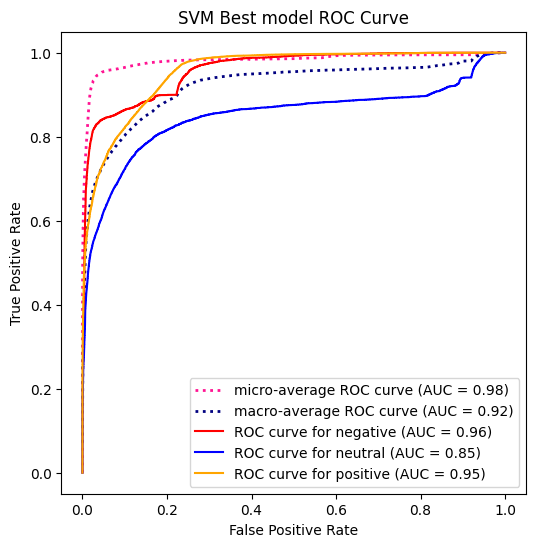

In [71]:
print(classification_report(y_test, y_test_pred))
print()
print("f1_score:", f1_score(y_test, y_test_pred, average="weighted"))
print("accuracy:", accuracy_score(y_test, y_test_pred))
print("precision:", precision_score(y_test, y_test_pred, average="weighted"))
print("roc_auc:", roc_auc_score(y_test, y_test_pred_proba, multi_class="ovr"))

### Code taken from scikit-learn
label_binarizer = LabelBinarizer().fit(y_train)
y_onehot_test = label_binarizer.transform(y_test)
y_onehot_test.shape  # (n_samples, n_classes)

class_of_interest = 1
class_id = np.flatnonzero(label_binarizer.classes_ == class_of_interest)[0]

fpr, tpr, roc_auc = dict(), dict(), dict()
# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_onehot_test.ravel(), y_test_pred_proba.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

print(f"Micro-averaged One-vs-Rest ROC AUC score:\n{roc_auc['micro']:.2f}")

for i in range(3):
    fpr[i], tpr[i], _ = roc_curve(y_onehot_test[:, i], y_test_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

fpr_grid = np.linspace(0.0, 1.0, 1000)

# Interpolate all ROC curves at these points
mean_tpr = np.zeros_like(fpr_grid)

for i in range(3):
    mean_tpr += np.interp(fpr_grid, fpr[i], tpr[i])  # linear interpolation

# Average it and compute AUC
mean_tpr /= 3

fpr["macro"] = fpr_grid
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

print(f"Macro-averaged One-vs-Rest ROC AUC score:\n{roc_auc['macro']:.2f}")

fig, ax = plt.subplots(figsize=(6, 6))

target_names = ['negative', 'neutral', 'positive']

plt.plot(
    fpr["micro"],
    tpr["micro"],
    label=f"micro-average ROC curve (AUC = {roc_auc['micro']:.2f})",
    color="deeppink",
    linestyle=":",
    linewidth=2,
)

plt.plot(
    fpr["macro"],
    tpr["macro"],
    label=f"macro-average ROC curve (AUC = {roc_auc['macro']:.2f})",
    color="navy",
    linestyle=":",
    linewidth=2,
)

colors = cycle(["red", "blue", "orange"])
for class_id, color in zip(range(3), colors):
    RocCurveDisplay.from_predictions(
        y_onehot_test[:, class_id],
        y_test_pred_proba[:, class_id],
        name=f"ROC curve for {target_names[class_id]}",
        color=color,
        ax=ax,
    )

_ = ax.set(
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    title="SVM Best model ROC Curve",
)